In [1]:
import itertools as iter
from itertools import product

import time

import pandas as pd
import numpy as np
import triangle as tri 

from scipy.stats import norm
from scipy.optimize import linprog

from matplotlib import pyplot as plt


from mpl_toolkits.mplot3d import Axes3D

import pypoman

import cdd as pcdd

import fractions as frac

In [2]:
def f(p): #funcion a evaluar
    x = p[0]
    y = p[1]
    if y <= 1.0e-6:
        y = 1.0e-6
    f = (1/y)*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))
    
    if f <= 1.0e-7:
        f = 1.1e-7
    return f

#gsl_cdf_ugaussian_P == norm.cdf
#These functions compute the cumulative distribution functions P(x), Q(x) and their inverses for the unit Gaussian distribution.


#gsl_ran_ugaussian_pdf == norm.pdf
#These functions compute results for the unit Gaussian distribution. They are equivalent to the functions above with a standard deviation of one, sigma = 1.

def df1dx (x,y): #funcion a evaluar
    if y <= 1.0e-6:
        y = 1.0e-6
    f = (1/y)*((norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))-(norm.pdf(x)-x*(1-norm.cdf(x))))
    return f  

def df1dy (x,y): #funcion a evaluar
    if y <= 1.0e-6:
        y = 1.0e-6
    f = -(1/(y*y))*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))+(1/y)*(norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))
    return f

def gradf(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y)])
def gradf2(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y),-1.0])

def fSH(a,x):
    return f(a) + np.dot(gradf(a),(x-a))

def e_i(n,i):
    vector = np.zeros(n)
    vector[i-1] = np.ones(1)[0]

    return vector

def pad(matriz, dimensiones):
    return np.pad(matriz,dimensiones, mode = 'constant', constant_values=(0, 0))

def linap (p,cuts, c,m):
    return max(c[str(cut)]+np.dot(m[str(cut)],p) for cut in cuts)

In [3]:
def to_points(triangulo):
    puntos = triangulo["vertices"]
    simplices = triangulo["triangles"]

    lista = []

    for pp in simplices:
        a = puntos[pp[0]]
        b = puntos[pp[1]]
        c = puntos[pp[2]]

        lista.append([a,b,c])

    return lista

def array_index(T, a):
    for i, arr in enumerate(T):
        if np.array_equal(arr, a):
            return i
    raise ValueError(f'{a} is not in list')

def triag_listo(T,v):
    a = v[0]
    b = v[1]
    c = v[2]
    
    aa = array_index(T,a)
    bb = array_index(T,b)
    cc = array_index(T,c)
    seg = [[aa,bb],[bb,cc],[cc,aa]]

    x = (a+b+c)/3
    return seg, x   

In [4]:
#Primera pasada
lb = float(1.0e-2)
ub = float(5.0)
a = np.array([lb,lb])
b = np.array([ub,ub])
og = False

k=0

X = dict()
Y = dict()
D = dict()

data = dict()

deltaabs = np.infty
deltarel = np.infty
epsabs = float(1.0e-4) #No cambiar de 1.0e-5
epsrel = float(1.0e-4)

if not og:
    bordes = np.array([a,[lb,ub],[ub,lb],b])
    dominio_temp = dict()

    dominio_temp["vertices"] = bordes

    triangulo_temp = tri.triangulate(dominio_temp, opts="qca0.1") #area!

    for p in triangulo_temp["vertices"]:
        k+=1
        deltaabs = max(f(p),0.0)
        deltarel = deltaabs/f(p)


        X[k] = p
        Y[k] = np.nan

        if deltaabs <= epsabs or deltarel <= epsrel:
            D[k] = 0
            Terminar = True

        data[k] = {"GEN": 0, "X": X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}
else:
    X[k] = e_i(2,2)*lb #R^2
    Y[k] = np.zeros(1) #R

    D[k] = 1

    data[k] = {"GEN": 0, "X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k], "f(x)": f(X[k]), "difabs": f(a)-0.0, "difrel": 1}


    while k < 1e6:
        Terminar = False

        soluciones = dict()

        p = X[k]

        for i in [1,2]:
            for c in [lb,ub]:

                lhsA = np.array([gradf(p),
                                e_i(2,i-1)])
                rhsb = np.array([np.dot(gradf(p),p)-f(p), c])

                ecs = np.linalg.solve(lhsA,rhsb)
                way = max(fSH(p,ecs),0.0)

                if np.less_equal(a/2.0,ecs).all() and np.less_equal(ecs,b+a/2.0).all():
                    soluciones[str(ecs)] = (ecs,way)

        if len(soluciones) < 1.0:
            ecs_s = b
            way_s = max(fSH(p,b),0)
            Terminar = True

        else:
            maximo = -1*np.infty
            for key in soluciones.keys():
                val = soluciones[key]
                if val[1] > maximo:
                    maximo = val[1]
                    ecs_s = val[0]
                    way_s = maximo

        deltaabs = f(ecs_s)-way_s
        deltarel = deltaabs/f(ecs_s)

        k+=1

        X[k] = ecs_s
        Y[k] = way_s

        if deltaabs <= epsabs or deltarel <= epsrel:
            D[k] = 0
            Terminar = True

        data[k] = {"GEN": 0, "X": X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}

        if Terminar:
            break

    df = pd.DataFrame(data).transpose()
    #Añade los vértices del cuadrado del dominio
    extremos = np.array([[0.0,ub],[ub,lb],b])
    for p in extremos:
        if p not in df["X"].values:
            k+=1
            X[k] = p
            Y[k] = 0.0
            data[k] = {"GEN": 0,"X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}
df = pd.DataFrame(data).transpose()

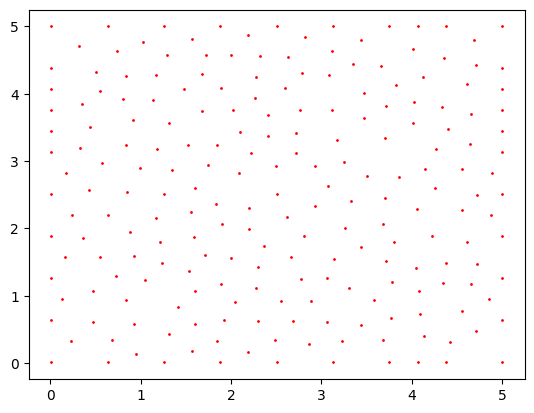

In [5]:
ex = df["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append((x[0]))
    py.append((x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

In [6]:
dominio = dict()

vertices = df["X"].values.tolist()
holes = []
segments = [[0,1],[1,3],[3,2],[2,0]]

dominio["vertices"] = vertices
dominio["segments"] = segments
#dominio["vertices"] = []

triangulo = tri.triangulate(dominio, opts="p")

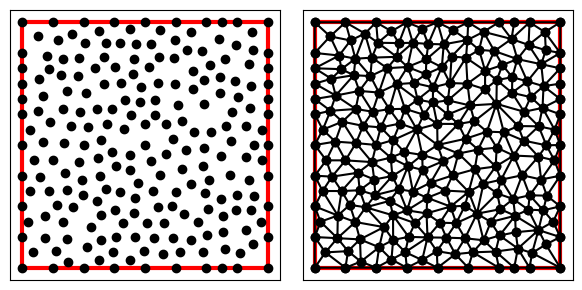

In [7]:
tri.compare(plt, dominio, triangulo)
plt.show()

In [8]:
def alg_S(x):
    return np.array([f(x) - np.dot(gradf(x),x)])
def alg_H(x,y):
    g = gradf(x)

    z = [-1.0]
    for y1 in y:
        z.append(np.dot(g,y1))
    return np.array(z)


In [9]:
#Segunda pasada
tandas = [to_points(triangulo)]
lim = 1000

ext = [[lb,ub],[ub,lb],b,a]

F_ext = np.array([[-1.0]])

Aeq= np.array([np.ones(5)- e_i(5,1)])

A_N = -np.array([e_i(5,2),e_i(5,3),e_i(5,4),e_i(5,5)])
S_N = np.zeros(4)


A_N     = pad(A_N,((0,4),(0,0))) + pad(np.array([e_i(5,2),e_i(5,3),e_i(5,4),e_i(5,5)]),((len(A_N),0),(0,0)))
S_N     = np.append(S_N,np.ones(4))
for x in ext:
    F_ext   = pad(F_ext,((0,1),(0,0))) + pad(np.array([[f(x)]]),((len(F_ext),0),(0,0)))

    A_N     = pad(A_N,((0,1),(0,0))) + pad(np.array([alg_H(x,ext)]),((len(A_N),0),(0,0)))
    S_N     = np.append(S_N,-alg_S(x))


flag = True
while k < lim and flag:
            
        Sys = linprog(-F_ext, A_eq=Aeq,b_eq=1.0,A_ub = A_N, b_ub = S_N, bounds = (None,None))

        if Sys.success:
            ecs_s = np.zeros(2)
            for lamda, p in zip(Sys.x[-4:],ext):
                ecs_s += lamda*np.array(p)
            way_s = Sys.x[0]

            if f(x) <= epsabs+way_s:
                
                
                flag = False
                break
            else:
                k+=1

                X[k] = ecs_s
                Y[k] = way_s

                data[k] = {"GEN": len(tandas), "X" :  X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(ecs_s),"difabs": deltaabs, "difrel":deltarel}
                vertices.append(ecs_s)

                A_N     = pad(A_N,((0,1),(0,0))) + pad(np.array([alg_H(ecs_s,ext)]),((len(A_N),0),(0,0)))
                S_N     = np.append(S_N,-alg_S(ecs_s))
        else:
            print(Sys)
            print("OH NO")
            print(0/0)
        
                

OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH SI
OH S

In [10]:
Sys

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.2800539000916584
              x: [ 2.640e-02 -0.000e+00 -0.000e+00  2.172e-01  7.828e-01]
            nit: 14
          lower:  residual: [       inf        inf        inf        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [-3.923e-01]
        ineqlin:  residual: [ 0.000e+00  0.000e+00 ... -3.027e-08
                             -3.027e-08]
                 marginals: [-2.448e-01 -9.746e-02 ... -0.000e+00
                             -0.000e

In [11]:
ecs_s

array([1.09382774, 1.09382774])

In [12]:
-F_ext

array([[ 1.00000000e+00],
       [-4.92071003e-02],
       [-1.10000000e-07],
       [-1.10000000e-07],
       [-3.91488823e-01]])

In [13]:
for x in A_N:
    print(x)

[ 0. -1.  0.  0.  0.]
[ 0.  0. -1.  0.  0.]
[ 0.  0.  0. -1.  0.]
[ 0.  0.  0.  0. -1.]
[0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1.]
[-1.00000000e+00 -4.99949740e-02 -3.94060591e-01 -4.43169226e-01
 -8.86338453e-04]
[-1.00000000e+00 -6.95132961e-07 -1.39808653e-06 -2.08904141e-06
 -4.17808282e-09]
[-1.00000000e+00 -2.04125294e-09 -5.34655238e-08 -5.53959848e-08
 -1.10791970e-10]
[-1.         -1.23831838 -2.47254733 -3.7034588  -0.00740692]
[-1.00000000e+00 -9.03600923e-02 -2.75699375e-01 -3.65328809e-01
 -7.30657618e-04]
[-1.         -0.58681942 -1.28674194 -1.86982172 -0.00373964]
[-1.         -0.30543193 -0.74258188 -1.04592196 -0.00209184]
[-1.         -0.18705295 -0.49610194 -0.6817913  -0.00136358]
[-1.         -0.13557589 -0.38203811 -0.51658084 -0.00103316]
[-1.00000000e+00 -1.12123391e-01 -3.27808035e-01 -4.39053319e-01
 -8.78106639e-04]
[-1.00000000e+00 -1.01022100e-01 -3.01474890e-01 -4.01693603e-01
 -8.03387206e-04]
[-1.00000000e+00 -9.56350713e-02 -2.

In [14]:
for x in S_N:
    print(x)

0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
-0.09920207430703823
-1.5080865335425718e-06
-1.6539598475066442e-07
-0.3988957402270336
-0.10625811634503723
-0.3199381079812834
-0.22678017713281307
-0.16904024475682797
-0.13809281278242436
-0.12225478778915486
-0.11427159768741264
-0.11026800120877152
-0.11227066801190186
-0.11126954158231629
-0.11177015782011342
-0.11202042633080894
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.11214555054487751
-0.1121455505448775

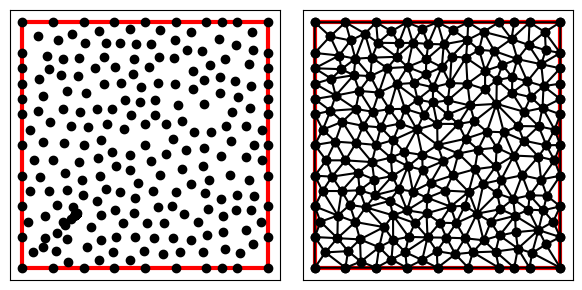

In [15]:
df2 = pd.DataFrame(data).transpose()
tri.compare(plt, dominio, triangulo)
plt.show()

In [16]:
print(k)
print(len(df2))

1000
1000


In [17]:
df2

,GEN,X,X1,X2,Y,f(x),difabs,difrel
1,0,"[0.01, 0.01]",0.01,0.01,NaN,0.391489,0.391489,1.0
2,0,"[0.01, 5.0]",0.01,5.0,NaN,0.049207,0.049207,1.0
3,0,"[5.0, 0.01]",5.0,0.01,NaN,0.0,0.0,1.0
4,0,"[5.0, 5.0]",5.0,5.0,NaN,0.0,0.0,1.0
5,0,"[2.505, 2.505]",2.505,2.505,NaN,0.000235,0.000235,1.0
...,...,...,...,...,...,...,...,...
996,1,"[1.0938277398210918, 1.0938277398210918]",1.093828,1.093828,0.026404,0.026404,0.081473,1.0
997,1,"[1.0938277398210918, 1.0938277398210918]",1.093828,1.093828,0.026404,0.026404,0.081473,1.0
998,1,"[1.0938277398210918, 1.0938277398210918]",1.093828,1.093828,0.026404,0.026404,0.081473,1.0
999,1,"[1.0938277398210918, 1.0938277398210918]",1.093828,1.093828,0.026404,0.026404,0.081473,1.0


In [18]:
#print(df2.to_markdown())

### POR QUE HAY VALORES NEGATIVOS?

Por mientras, los parchearé a la mala...

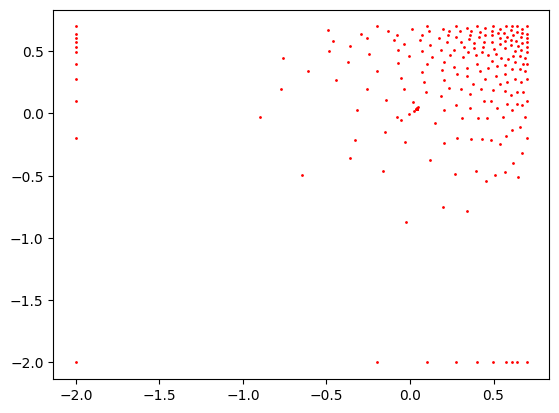

In [19]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(np.log10(x[0]))
    py.append(np.log10(x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

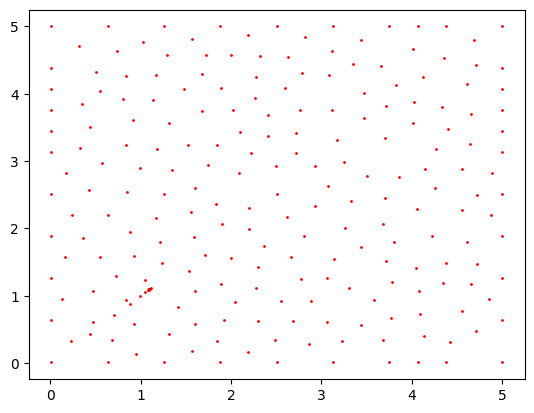

In [20]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(x[0])
    py.append(x[1])


plt.scatter(px, py, s=1, c = "red")
plt.show()

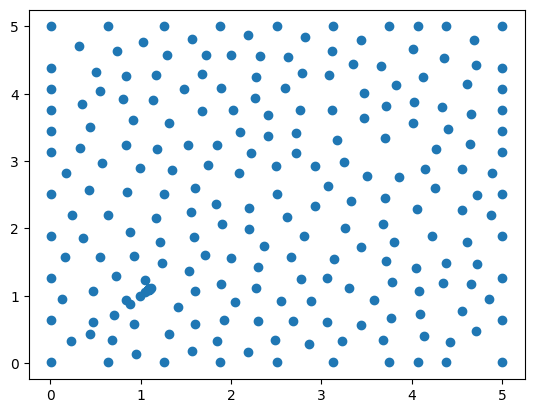

In [21]:
pepes = df2["X"].values.tolist()

pepes = np.array(pepes)

tri2 = tri.triangulate({"vertices": pepes}, "c")
plt.plot(pepes[:,0], pepes[:,1], 'o')
plt.show()

In [22]:
print(len(df2)-len(df), len(df))

786 214


In [23]:
puntox1  = np.random.rand(1000,2)*(ub-lb)+lb
puntox2  = []

for n in puntox1:
    puntox2.append(np.array([n[0], n[1], f(n)]))
puntox2 = np.array(puntox2)


In [24]:
def f(p): #funcion a evaluar
    x = p[0]
    y = p[1]
    
    f = (1/y)*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))
    
    return f

#gsl_cdf_ugaussian_P == norm.cdf
#These functions compute the cumulative distribution functions P(x), Q(x) and their inverses for the unit Gaussian distribution.


#gsl_ran_ugaussian_pdf == norm.pdf
#These functions compute results for the unit Gaussian distribution. They are equivalent to the functions above with a standard deviation of one, sigma = 1.

def df1dx (x,y): #funcion a evaluar
    f = (1/y)*((norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))-(norm.pdf(x)-x*(1-norm.cdf(x))))
    return f  

def df1dy (x,y): #funcion a evaluar
    f = -(1/(y*y))*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))+(1/y)*(norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))
    return f

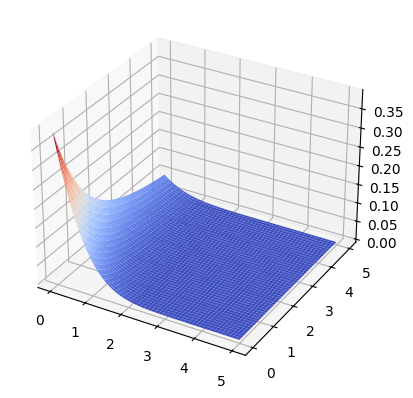

In [25]:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

#X = puntox2[:,0]
X = np.arange(lb, ub, 0.01)
Y = np.arange(lb, ub, 0.01)
#Y = puntox2[:,1]

X,Y = np.meshgrid(X,Y)

Z = f((X,Y))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

plt.show()


In [26]:
Teacher_cuts = pd.read_excel(r'C:\Users\nico_\Desktop\mem\Codigos\profe\Code_C_shortage_barrido\cortes.xlsx', header = 0).iloc[:,1:3]

In [27]:
Teacher_cuts

,param x1:=,param y1:=
0,x,y
1,0,0.000001
2,0,1.596001
3,0,3.486001
4,1.12,0.000001
...,...,...
1997,1.158,0.951001
1998,0.326,1.490001
1999,2.046,1.885001
2000,0.027,1.219001


C:\Users\nico_\AppData\Local\Temp\ipykernel_13436\3059026019.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  px.append(x[0])
C:\Users\nico_\AppData\Local\Temp\ipykernel_13436\3059026019.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  py.append(x[1])


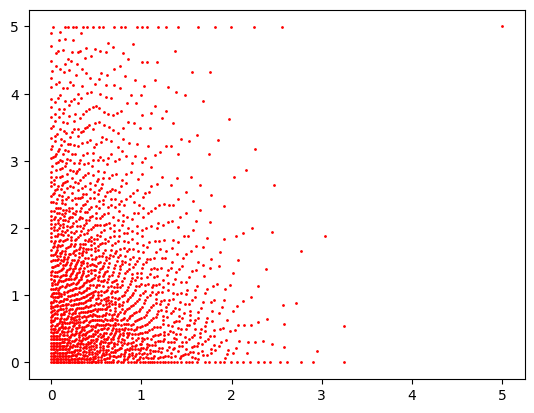

C:\Users\nico_\AppData\Local\Temp\ipykernel_13436\3059026019.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[0] == 0:
C:\Users\nico_\AppData\Local\Temp\ipykernel_13436\3059026019.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  px2.append(np.log10(x[0]))
C:\Users\nico_\AppData\Local\Temp\ipykernel_13436\3059026019.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  py2.append(np.log10(x[1]))


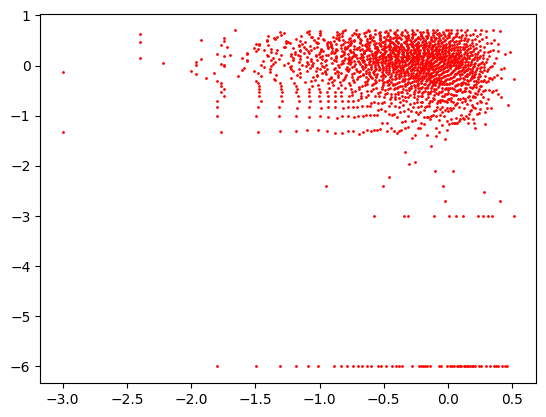

In [28]:
px = []
px2 = []
py = []
py2 = []

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        px.append(x[0])
        py.append(x[1])

px.append(ub)
py.append(ub)
plt.scatter(px, py, s=1, c = "red")
plt.show()

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        if x[0] == 0:
            continue
        px2.append(np.log10(x[0]))
        py2.append(np.log10(x[1]))


plt.scatter(px2, py2, s=1, c = "red")
plt.show()

In [29]:
print()

## Comprobación ##


In [30]:
my_cuts = df2.iloc[:,1:4]

In [31]:
cuts = my_cuts.iloc[:,0].values

c = dict()
m = dict()

for cut in cuts:
    c[str(cut)] = f(cut) - np.dot(gradf(cut),(cut))
    m[str(cut)] = gradf(cut)

In [32]:
for n in range(0,100,1):
    linap(np.array([2,2]),cuts,c,m)

KeyboardInterrupt: 

In [33]:
n=45

contador = 0
h = (ub-lb)/n
doomx = []
doomy = []

x = 0.0
while x < ub:
    y = lb
    while y < ub:
        z = linap(np.array([x,y]),cuts,c,m)
        if f((x,y)) >= epsabs + z:
            doomx.append(x)
            doomy.append(y)
            contador+=1
        y+= h
    x+= h

KeyboardInterrupt: 

In [ ]:
contador/n**2

# $Old$

2k cortes: 3.84%

1k cortes: 7.52%

500 cortes: 12.48%

250 cortes: 19.68%


# $New$

2k cortes: 0.00%

1k cortes: 2.47%

500 cortes: 9.36%

250 cortes: 17.91%

In [ ]:
px = []
py = []

for n in range(len(doomx)):
    x = doomx[n]
    y = doomy[n]
    px.append(x)
    py.append(y)

plt.scatter(px, py, s=10, c = "red")


plt.scatter(df2["X1"], df2["X2"], s=1, c = "blue")
plt.show()